# **Quantum vs. classical classifier**

## This is an example of a classifier that can be found in the [ket.G](https://www.youtube.com/watch?v=KpISXCH9GbE&list=PLhYoqmIacCv9i4oXByNyY9zf4SKTi0_Zk&index=5) videos


The first step is to import the libraries, pennylane is a library specialised in quantum machine learning.

In [1]:
import pennylane as qml
from pennylane import numpy as np 
import matplotlib.pyplot as plt

Next we create our data samples, we will use 200 data of which 1/4 will follow a Gaussian distribution centred on x=-2 and y=2 (set A), set B (x=2, y=-2), set C (x=2, y=2) and D(x=-2, y=-2). Where, set A and B will be a single set (orange) and C and D the blue set.

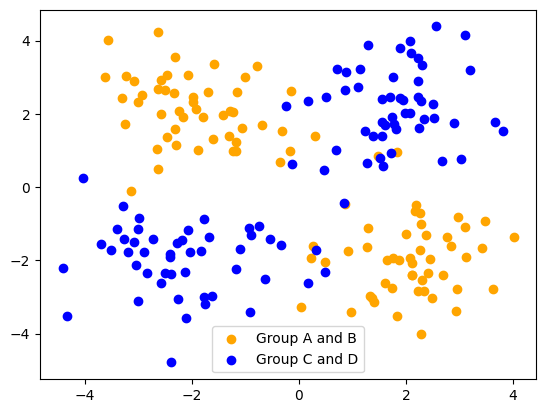

In [2]:


n_samples = 200
A = np.array([[np.random.normal(loc=-2), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
B = np.array([[np.random.normal(loc=2), np.random.normal(loc=-2)] for i in range(n_samples//4)]) 
C = np.array([[np.random.normal(loc=2), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
D = np.array([[np.random.normal(loc=-2), np.random.normal(loc=-2)] for i in range(n_samples//4)]) 

plt.scatter(A[:,0], A[:,1], color = "orange", label = 'Group A and B')
plt.scatter(B[:,0], B[:,1], color = "orange")
plt.scatter(C[:,0], C[:,1], color = "blue", label = 'Group C and D')
plt.scatter(D[:,0], D[:,1], color = "blue")
plt.legend()
plt.show()


The next step is to classify our data, so we start by creating a matrix with all our data (we concatenate points A, B, C and D), along an axis (be consistent and choose the same axis in feature as in label).
Next, as we have indicated we have two sets of data: orange and blue, what we will do is give the first a value of -1 and the other half a value of 1.
With data, we create a matrix that correlates the values. zip is like creating a kind of dictionary, saving distances.

In [3]:
feature = np.concatenate([A,B,C,D], axis=0)
label = np.concatenate([-np.ones(n_samples // 2), np.ones(n_samples//2)], axis=0)
data = list(zip(feature, label))

We start with the classical model, a simple model with a derivable sign function that allows us to look for the minimum with the gradient, this function is arctan (normalised with np.pi/2) that looks for a linear equation: -w$_{1}$*y$_{i}$ = -w$_{0}$*x$_{i}$ + w$_{2}$

In [4]:
def classical_model(x, w):
    return np.arctan(x[0]*w[0] + x[1]*w[1] + w[2]) / (np.pi / 2)
    #return np.sing(x[0]*w[0] + x[1]*w[1] + w[2]) al aplicar el gradiente no va a poder derivar y no provocará la evolución del plano

We now proceed with the quantum model, in this case we have two inputs (x,y coordinates) so we will use two qubits, what we will play with will be the phases in the Bloch sphere, we will make rotations in these qubits to bring them closer (or not) to the state |1>, the first term allows us to play with the amplitude (w$_{2}$, w$_{3}$) seeing where our data are (x$_{i}$, y$_{i}$), then we apply the same circuit for the rotations of the weights w$_{0}$ and w$_{1}$, this is important because they are the ones that will position us where the groups are, it must have the same form as the equation above.
Finally, for a reason that is not clear to me, we measure in a single qubit, this implies communicating the two qubits, we use a cnot

In [5]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def quantum_model(x, w):
    
    qml.RX(x[0]*w[2], wires = 0)
    qml.RX(x[1]*w[3], wires = 1)
    
    qml.RX(w[0], wires = 0)
    qml.RX(w[1], wires = 1)
    qml.CNOT(wires = [1,0])

    
    return qml.expval(qml.PauliZ(wires = 0))
print(qml.draw(quantum_model)(x=[1,2], w=[-1., -0.2, 3.,0.5]))

0: ──RX(3.00)──RX(-1.00)─╭X─┤  <Z>
1: ──RX(1.00)──RX(-0.20)─╰●─┤     


Simplemente, creamos una función para representar la clasificación

In [6]:
limit = np.pi
x = np.arange(-limit, limit, 0.2)
y = np.arange(-limit, limit, 0.2)

# Calculating the output and storing it in the array Z

def plot(f):
    Z = np.zeros([len(x), len(y)])
    for ind, i in enumerate(x):
        for ind2, j in enumerate(y):
            Z[ind,ind2] = f([i, j],w)

    im = plt.imshow(Z, extent=(-limit, limit, -limit, limit), interpolation='bilinear')
    plt.scatter(A[:,0], A[:,1], color = "orange")
    plt.scatter(B[:,0], B[:,1], color = "orange")
    plt.scatter(C[:,0], C[:,1], color = "blue")
    plt.scatter(D[:,0], D[:,1], color = "blue")
    plt.axis((-limit,limit,-limit,limit))
    plt.colorbar(im);

    plt.show()
    

Diseñamos una función para calcular el error de nuestro clasificador, nos dice como se aleja nuestro modelo de los puntos y lo elevamos al cuadrado con la finalidad de ver cuanto falla, esta fución se minimizará con el gradiente

In [7]:
def average_loss(w, data, model):
    losses = 0
    for x,y in data:
        losses += (model(x,w) - y) ** 2
    return losses/len(data)

Aquí tenemos la función gradiente, que minimizará nuestras perdidas

In [8]:
gradient_fn_w = qml.grad(average_loss, argnum=0)

epoch 0 loss 1.4337832102294725


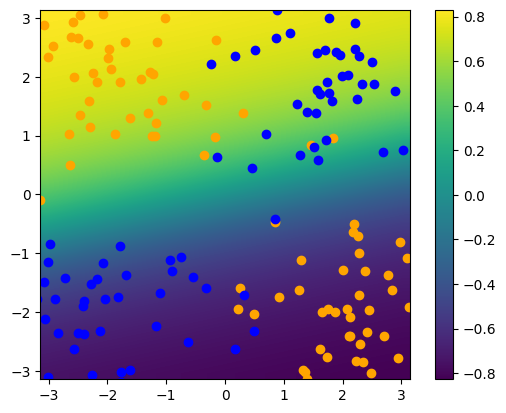

epoch 5 loss 1.3568029395677943


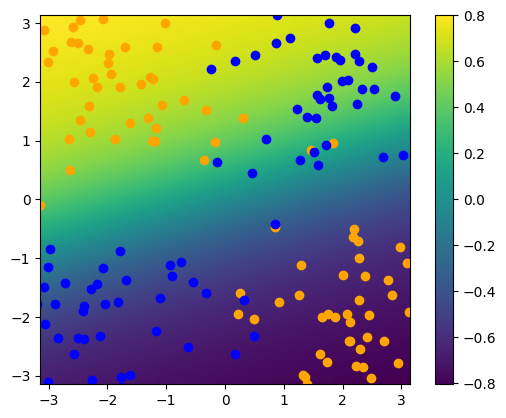

epoch 10 loss 1.2293404190482322


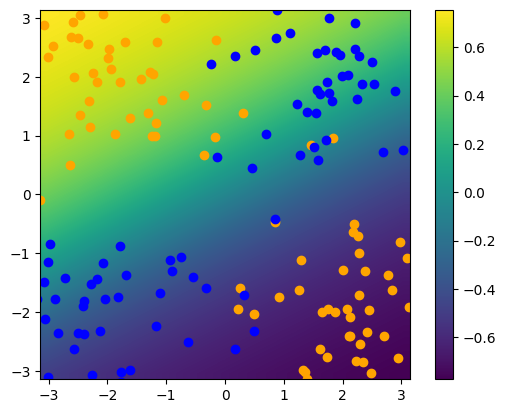

epoch 15 loss 1.1064086656277694


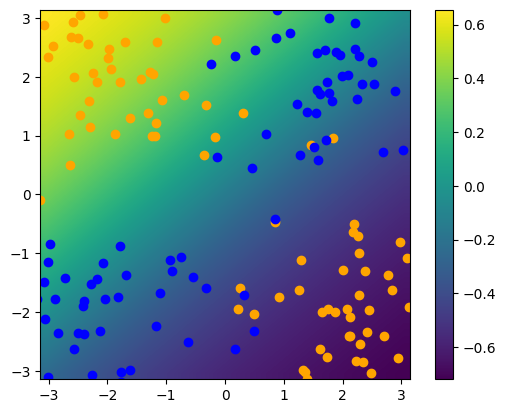

epoch 20 loss 1.0584772796002953


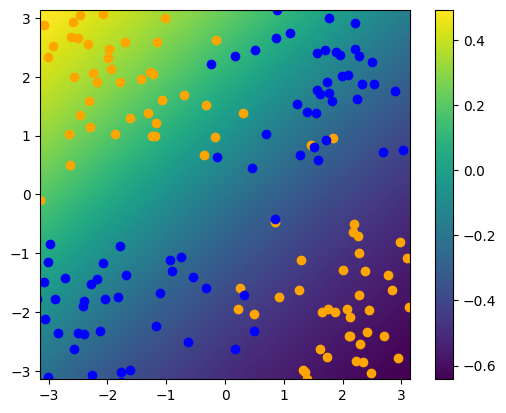

epoch 25 loss 1.043585298659521


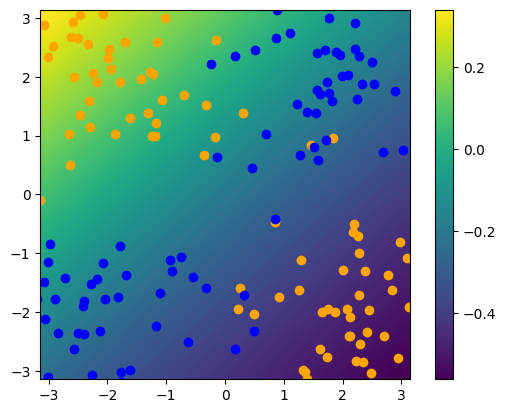

epoch 30 loss 1.0342605397193245


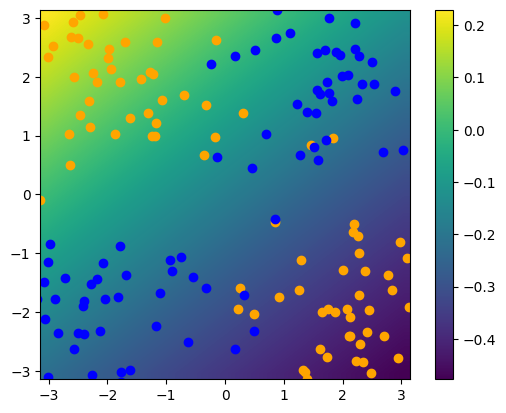

epoch 35 loss 1.022832288375072


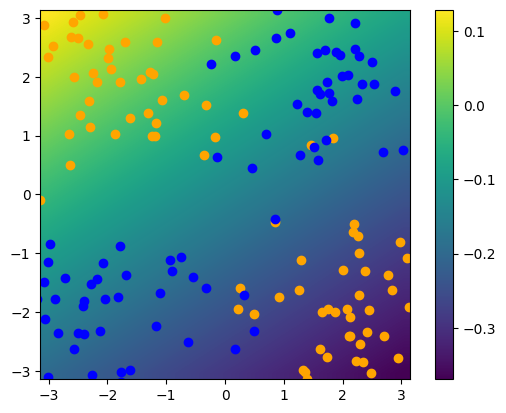

epoch 40 loss 1.0110516835670196


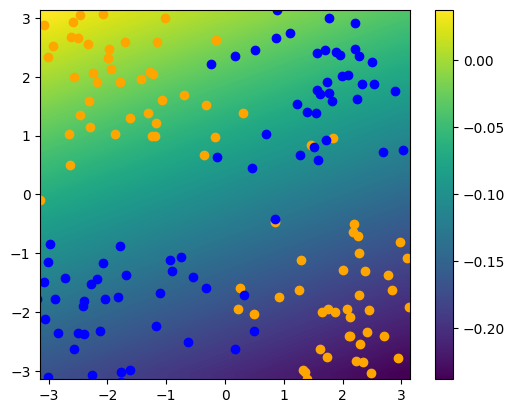

epoch 45 loss 1.0037348829158268


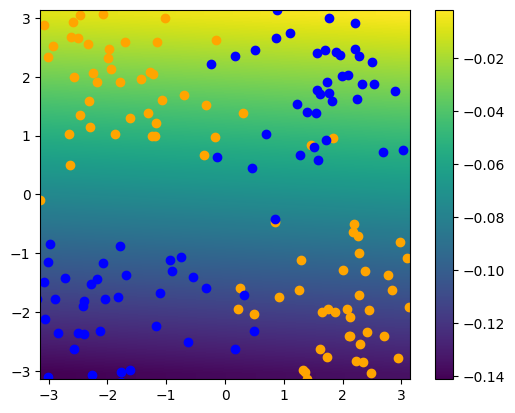

epoch 50 loss 1.0005316562041384


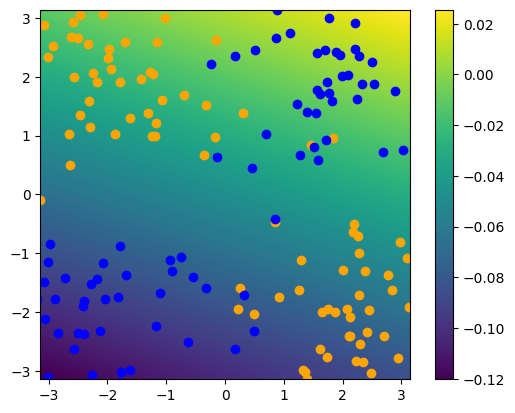

epoch 55 loss 0.9991508266648046


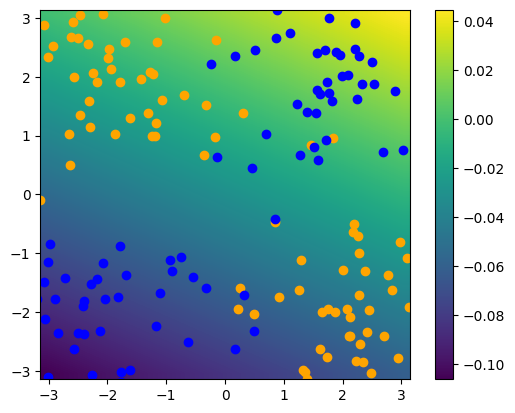

epoch 60 loss 0.9985448160230136


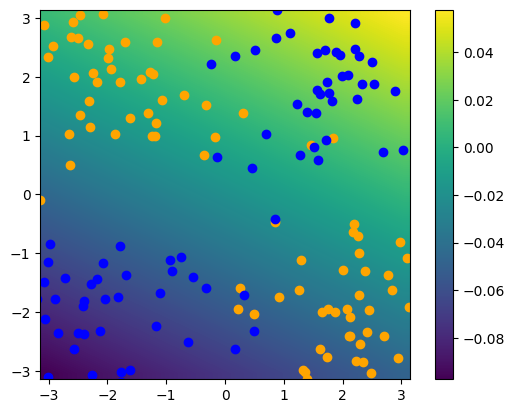

epoch 65 loss 0.9982788367970459


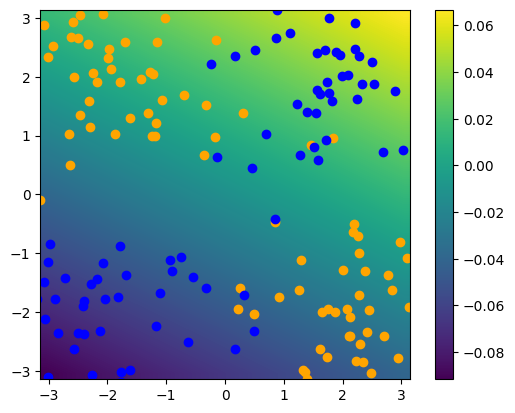

epoch 70 loss 0.998162143398513


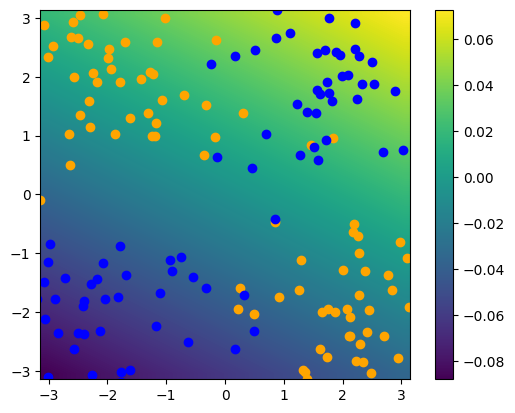

epoch 75 loss 0.9981109222322955


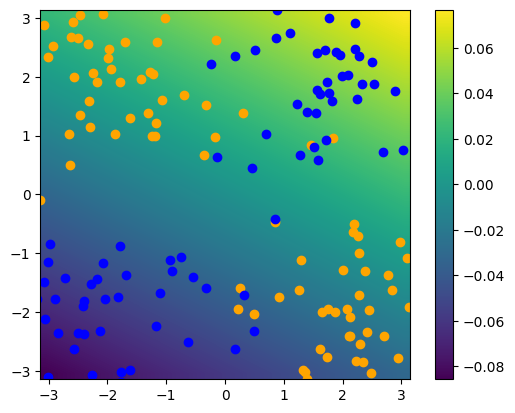

epoch 80 loss 0.9980884234320173


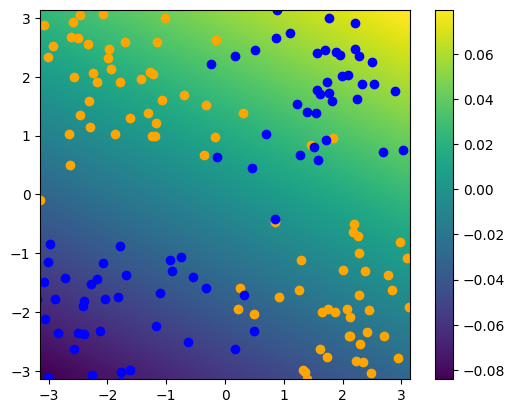

epoch 85 loss 0.9980785344488744


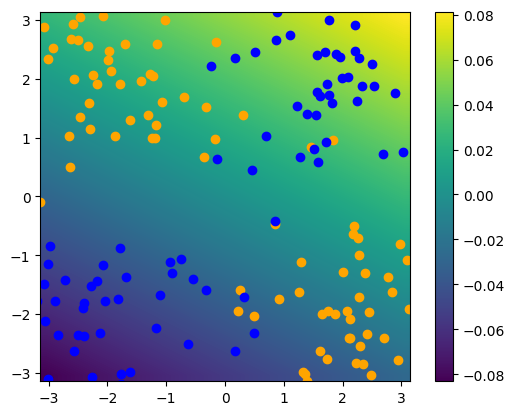

epoch 90 loss 0.9980741856750821


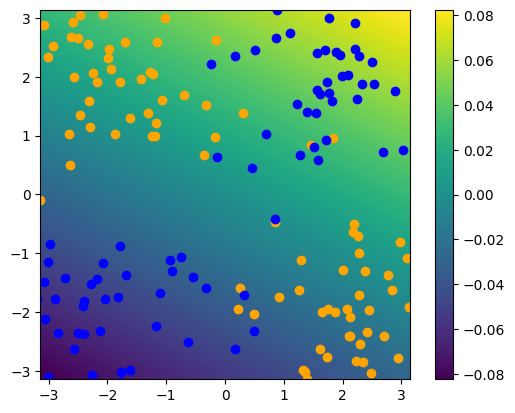

epoch 95 loss 0.9980722725393427


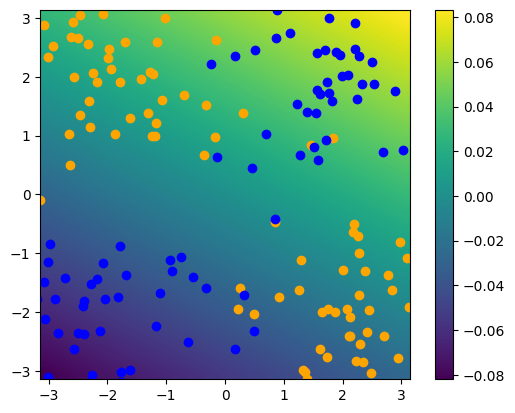

epoch 100 loss 0.9980714306781503


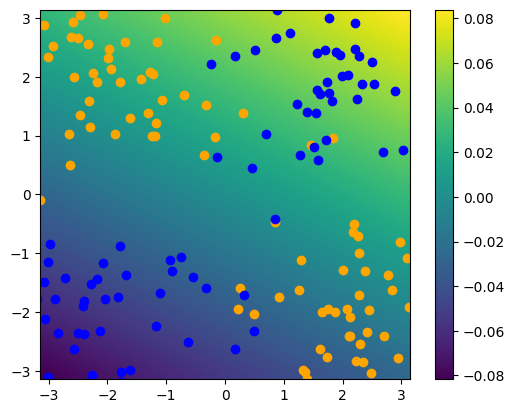

In [9]:
from IPython.display import clear_output
w = np.array([-1., -0.2, 0.,0.5], requires_grad = True)

lr = 0.1
for epoch in range(101):
    w = w - lr*gradient_fn_w(w,data, classical_model)
    if epoch % 5 == 0:
        print("epoch", epoch, "loss", average_loss(w,data,classical_model))
        plot(classical_model)
        #clear_output(wait=True)

epoch 0 loss 1.0900332020271604


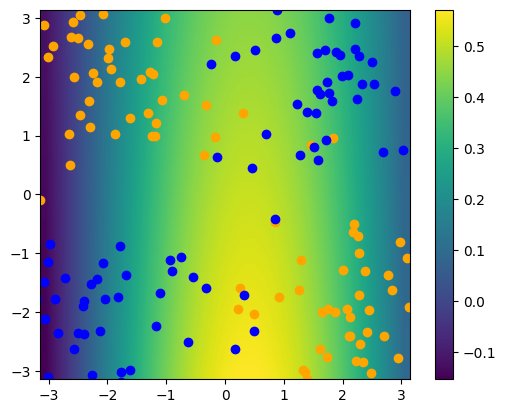

epoch 5 loss 1.017216957536422


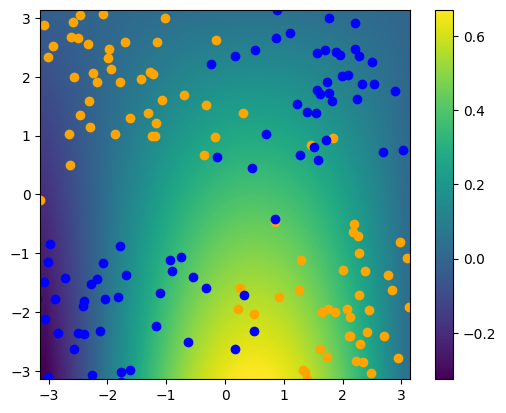

epoch 10 loss 0.8606705118319282


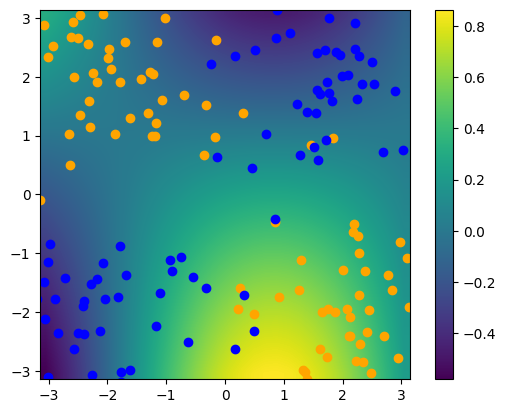

epoch 15 loss 0.5538998708125292


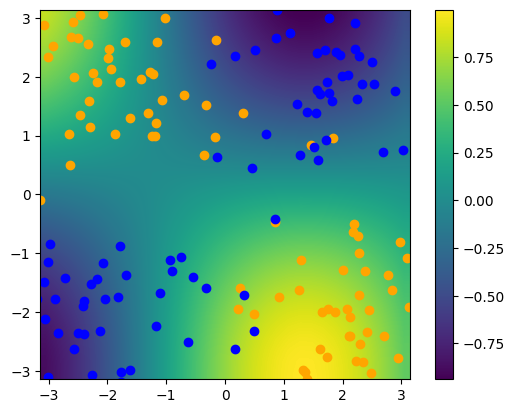

epoch 20 loss 0.36639495713766346


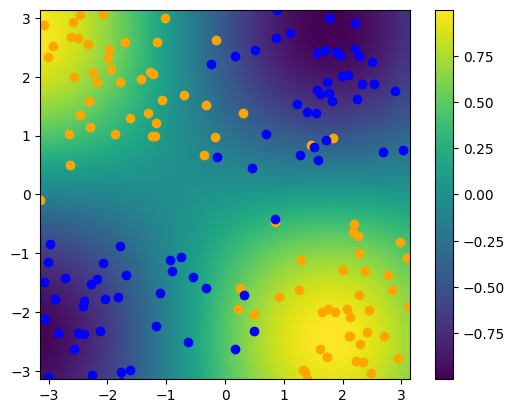

epoch 25 loss 0.29755101688519214


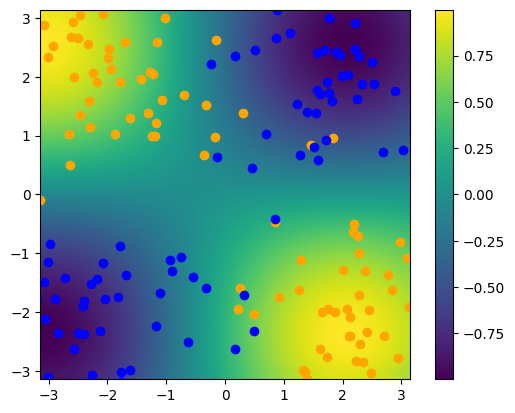

epoch 30 loss 0.2679931574136343


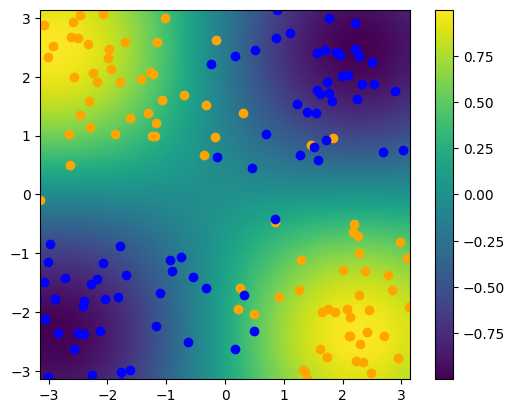

epoch 35 loss 0.25403407106078346


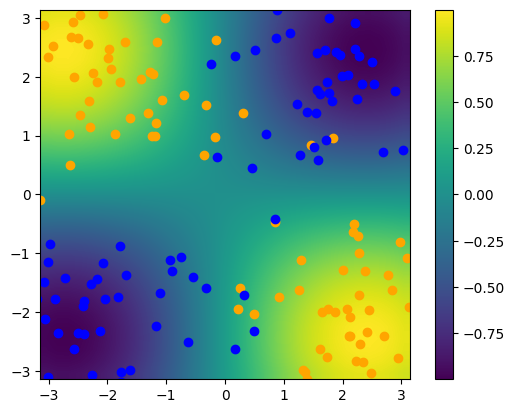

epoch 40 loss 0.24725861408159727


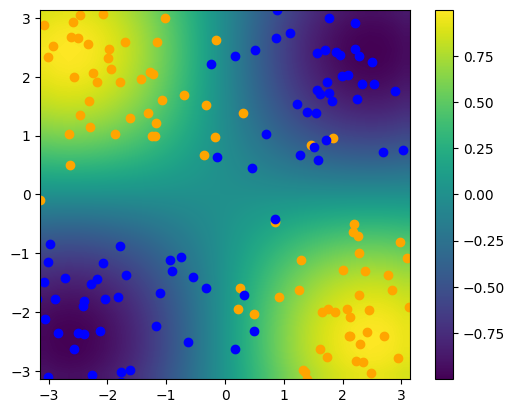

epoch 45 loss 0.2439281608346776


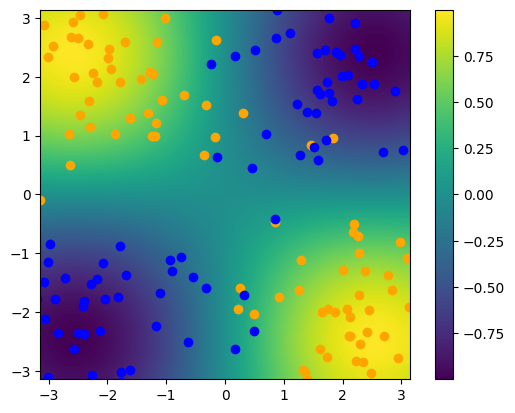

epoch 50 loss 0.24227879522165005


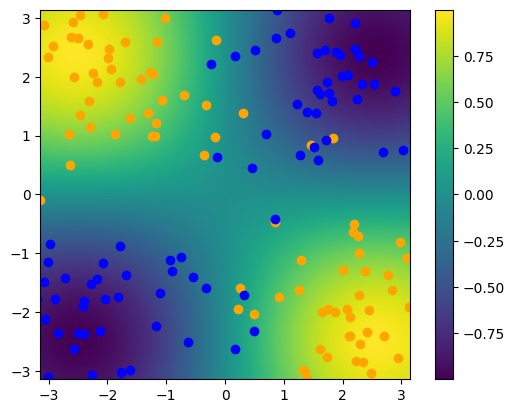

epoch 55 loss 0.24145818607913494


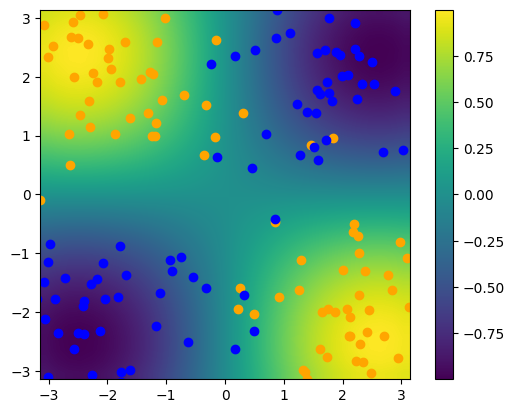

epoch 60 loss 0.24104872477698225


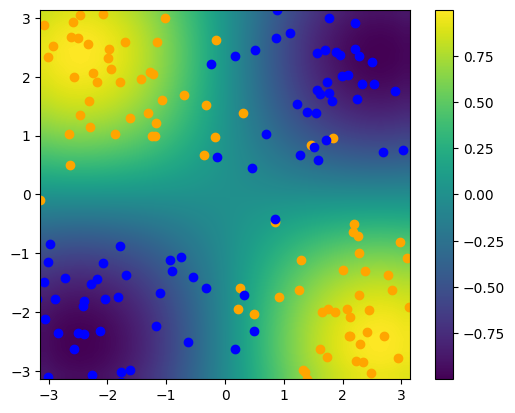

epoch 65 loss 0.24084403709521815


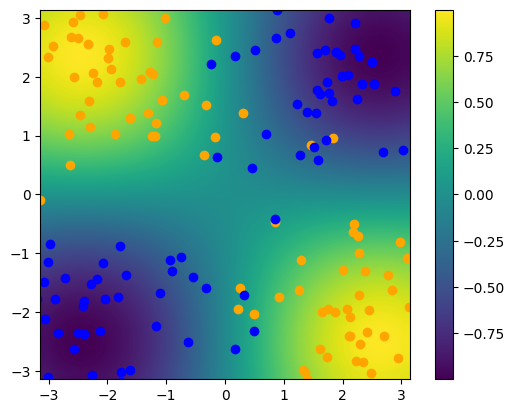

epoch 70 loss 0.24074159156565794


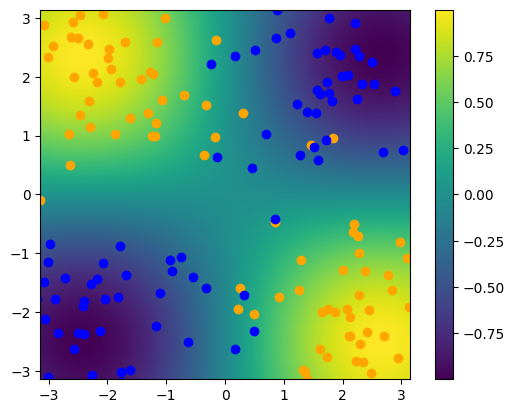

epoch 75 loss 0.24069027694867512


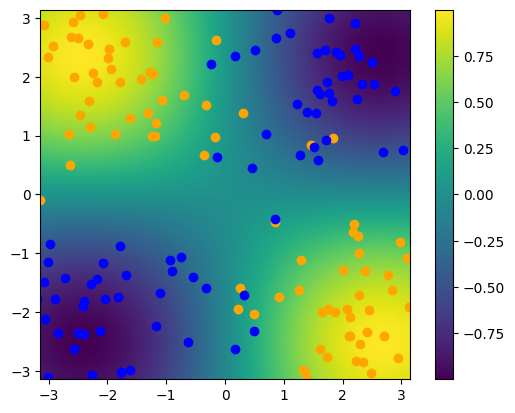

epoch 80 loss 0.24066455977539292


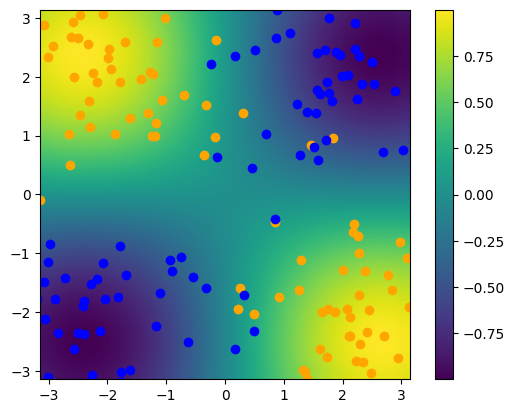

epoch 85 loss 0.2406516664304563


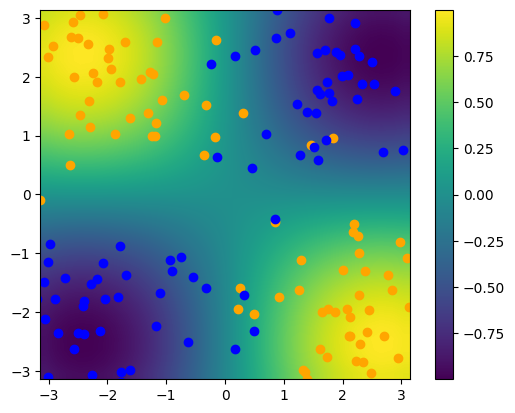

epoch 90 loss 0.2406452006796142


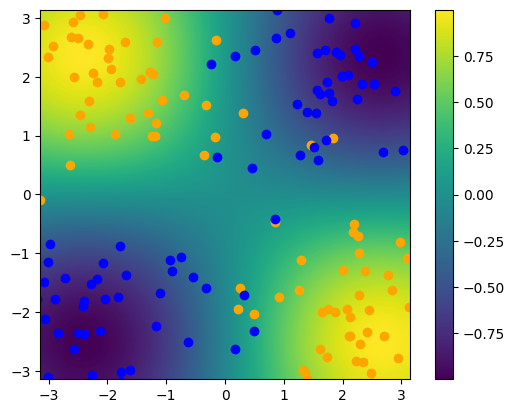

epoch 95 loss 0.24064195765688595


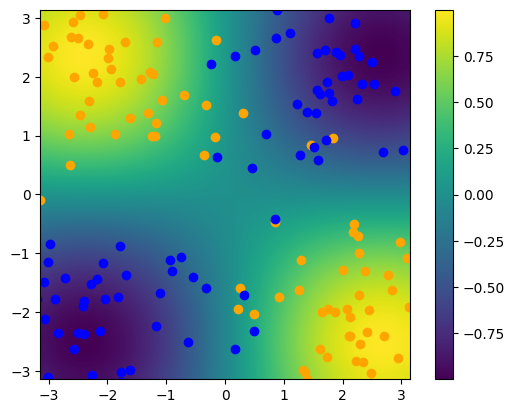

epoch 100 loss 0.24064033085055134


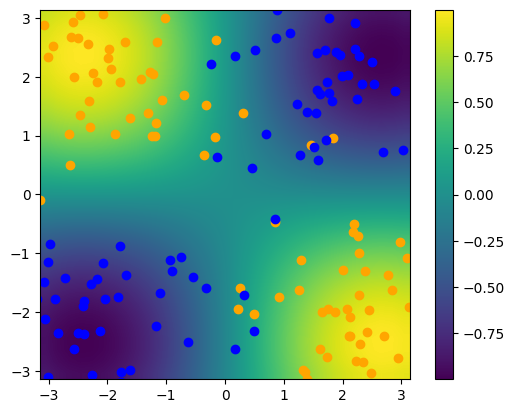

In [10]:
from IPython.display import clear_output
w = np.array([-1., -0.2, 0.,0.5], requires_grad = True)

lr = 0.1
for epoch in range(101):
    w = w - lr*gradient_fn_w(w,data, quantum_model)
    if epoch % 5 == 0:
        print("epoch", epoch, "loss", average_loss(w,data,quantum_model))
        plot(quantum_model)
        #clear_output(wait=True)